# In this code, I will predict a time series using only a single layer neural network. This architecture resembles a regression model where I will use only a single neuron in the dense layer

### Import the libraries

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

### Define the utility functions for reusing

In [20]:
# Define the series plotting function
def plot_series(time, series, format="-", start=0, end=None):

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

# Define the trend line
def trend(time, slope=0):

    # Compute the linear series given the slope
    series = slope * time

    return series

# Define a random seasonal pattern
def seasonal_pattern(season_time):

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.3,
                    np.sin(season_time * 3 * np.pi),
                    2 / np.exp(5.34 * season_time))

    return data_pattern

# Define the seasonality
def seasonality(time, period, amplitude=1.5, phase=0):

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

# Define the noise
def noise(time, noise_level=1, seed=None):

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

### Generate synthetic data

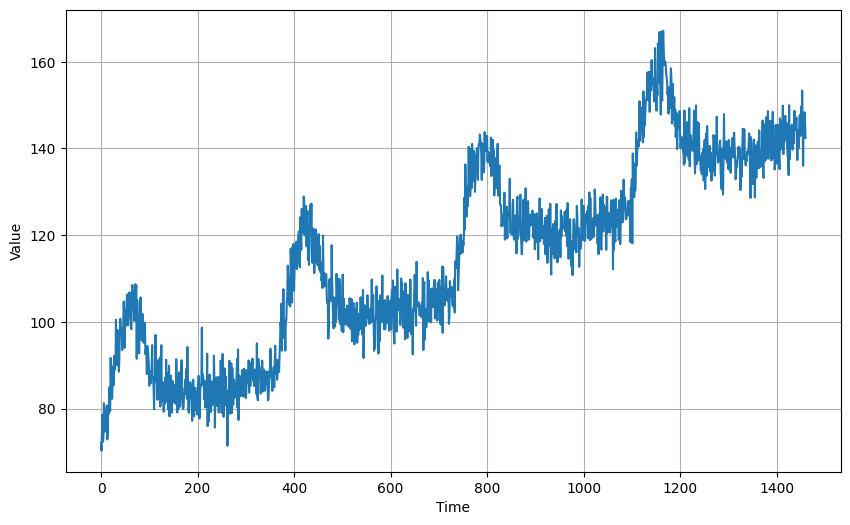

In [21]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 70
amplitude = 30
slope = 0.05
noise_level = 4

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

### Split the dataset into training validation series

In [22]:
# Define the split time
split_time = 1050

# Get the train set
time_train = time[:split_time]
series_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
series_valid = series[split_time:]

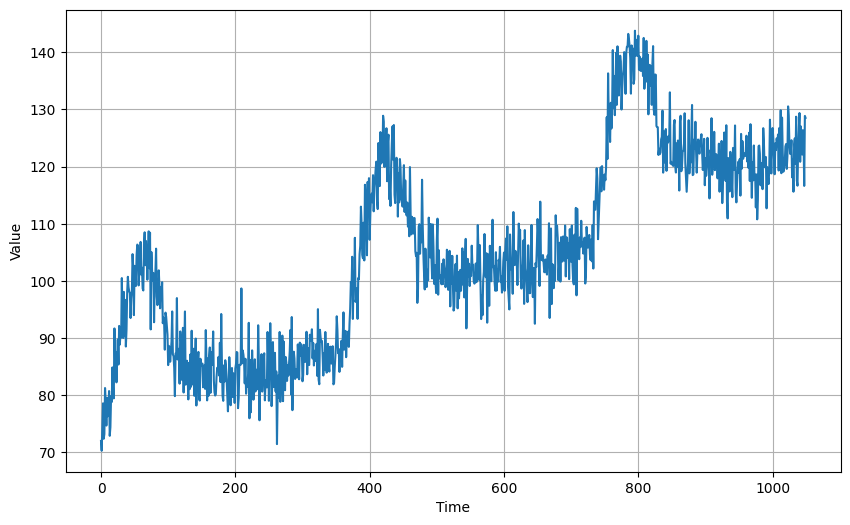

In [24]:
# Plot the train set
plot_series(time_train, series_train)

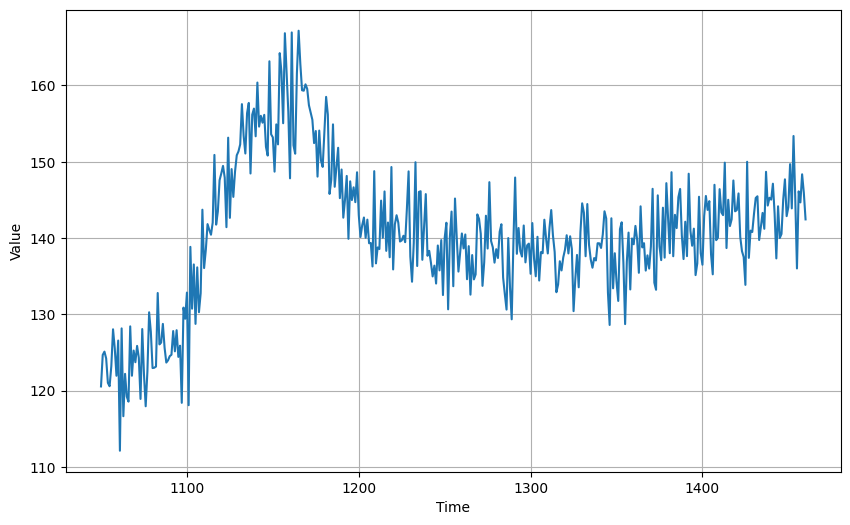

In [25]:
# Plot the validation set
plot_series(time_valid, series_valid)

# Prepare features and labels

In [26]:
# Parameters
window_size = 15
batch_size = 32
shuffle_buffer_size = 1500

In [27]:
# Generate a windowed dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [28]:
# Generate the dataset windows
dataset = windowed_dataset(series_train, window_size, batch_size, shuffle_buffer_size)

In [29]:
# Print properties of a single batch
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 15)
shape of second element: (32,)


# Build and compile the model

In [30]:
# Build the single layer neural network
l0 = keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

# Print the initial layer weights
print("Layer weights: \n {} \n".format(l0.get_weights()))

# Print the model summary
model.summary()

Layer weights: 
 [array([[ 0.15351814],
       [-0.46749935],
       [-0.2857525 ],
       [ 0.24265581],
       [-0.39747596],
       [-0.29759508],
       [ 0.04171586],
       [ 0.22593856],
       [-0.52543384],
       [ 0.20895994],
       [-0.06984276],
       [-0.46349645],
       [ 0.08753282],
       [ 0.40185803],
       [-0.48556173]], dtype=float32), array([0.], dtype=float32)] 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 16        
                                                                 
Total params: 16 (64.00 Byte)
Trainable params: 16 (64.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
# Set the training parameters
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.8))

# Train the Model

In [32]:
# Train the model
model.fit(dataset,epochs=100)

Epoch 1/100
33/33 [==============================] - 1s 4ms/step - loss: 6545.5210
Epoch 2/100
33/33 [==============================] - 0s 2ms/step - loss: 51.4729
Epoch 3/100
33/33 [==============================] - 0s 2ms/step - loss: 42.6103
Epoch 4/100
33/33 [==============================] - 0s 2ms/step - loss: 42.1874
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 43.6943
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 41.8164
Epoch 7/100
33/33 [==============================] - 0s 2ms/step - loss: 42.0204
Epoch 8/100
33/33 [==============================] - 0s 2ms/step - loss: 40.9940
Epoch 9/100
33/33 [==============================] - 0s 2ms/step - loss: 41.3711
Epoch 10/100
33/33 [==============================] - 0s 1ms/step - loss: 43.0793
Epoch 11/100
33/33 [==============================] - 0s 1ms/step - loss: 40.8206
Epoch 12/100
33/33 [==============================] - 0s 1ms/step - loss: 40.4497
Epoch 13/100
33/33 [===

In [33]:
# Print the layer weights
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[ 0.14262794],
       [-0.21304823],
       [-0.09082069],
       [ 0.24485657],
       [-0.12368029],
       [-0.04877184],
       [ 0.15347655],
       [ 0.24555916],
       [-0.17402461],
       [ 0.28335527],
       [ 0.12818873],
       [-0.11770386],
       [ 0.22482558],
       [ 0.44420314],
       [-0.08593869]], dtype=float32), array([0.00293586], dtype=float32)]


# Model Prediction

In [34]:
# Initialize a list
forecast = []

# Use the model to predict data points per window size
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# Slice the points that are aligned with the validation set
forecast = forecast[split_time - window_size:]

# Compare number of elements in the predictions and the validation set
print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {series_valid.shape}')

1/1 [==============================] - 0s 24ms/step
length of the forecast list: 411
shape of the validation set: (411,)


shape after converting to numpy array: (411, 1, 1)
shape after squeezing: (411,)


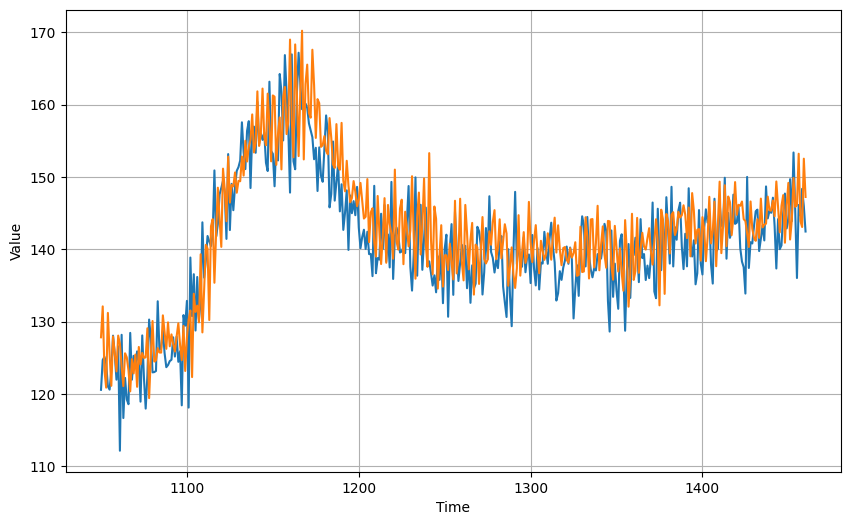

In [36]:
# Preview shapes after using the conversion and squeeze methods
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Overlay the results with the validation set
plot_series(time_valid, (series_valid, results))

In [37]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(series_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(series_valid, results).numpy())

32.462807
4.4763937
